In [284]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re, os

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import LayerNormalization, LeakyReLU
from keras.optimizers import Adam


In [251]:
data = pd.read_csv('/home/hasan/DATA SET/Fake News/train.csv')

In [252]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Handling missing values

In [253]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [254]:
data['title'].fillna(method='ffill', inplace=True)
data['author'].fillna(method='bfill', inplace=True)
data['text'].fillna(method='ffill', inplace=True)

In [255]:
data['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

### Seperating feature and label data

In [256]:
X = X.copy()

In [257]:
X = data.drop(['label'], axis=1)
y = data['label']
print('Shape of X is :',X.shape)
print('Shape of y is :',y.shape)

Shape of X is : (20800, 4)
Shape of y is : (20800,)


In [258]:
#resetting index
X.reset_index(inplace=True)
X.drop('index', axis=1, inplace=True)

In [259]:
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


### Text Cleaning

In [260]:
ps = PorterStemmer()

In [261]:
corpus = []
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    

In [262]:
corpus[3]

'civilian kill singl us airstrik identifi'

### One_Hot of Word

In [263]:
one_hot_repre = [one_hot(words, 500) for words in corpus]

In [264]:
#printing 
for i in range(0,5):
    print(one_hot_repre[i])

[209, 303, 186, 219, 192, 298, 252, 437, 282, 362]
[366, 498, 194, 316, 307, 414, 382]
[329, 79, 124, 351]
[412, 61, 56, 209, 135, 304]
[46, 307, 413, 32, 177, 224, 307, 477, 22, 118]


### Embedding Representation

In [265]:
embedded = pad_sequences(one_hot_repre, padding='post', maxlen=20)

In [266]:
print(embedded)
print('\n\nShape of embedded is :',embedded.shape)

[[209 303 186 ...   0   0   0]
 [366 498 194 ...   0   0   0]
 [329  79 124 ...   0   0   0]
 ...
 [346  15   1 ...   0   0   0]
 [325 271 358 ...   0   0   0]
 [188 189 174 ...   0   0   0]]


Shape of embedded is : (20800, 20)


In [267]:
embedded[2]

array([329,  79, 124, 351,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Converting to Array

In [268]:
X_final = np.array(embedded)
y_final = np.array(y)
print('Shape of X_final is :',X_final.shape)
print('Shape of y_final is :',y_final.shape)

Shape of X_final is : (20800, 20)
Shape of y_final is : (20800,)


### Dividing Data Set

In [269]:
Xtrain,xvalid, Ytrain,yvalid = train_test_split(X_final,y_final, test_size=.2, random_state=42)

### Model

In [270]:
model = Sequential()
model.add(Embedding(5000, 40, input_length=20))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


In [271]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 20, 40)            200000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [272]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.0005),
              metrics=['accuracy'])

In [273]:
model_history = model.fit(Xtrain,Ytrain, epochs=10, batch_size=64, validation_data=(xvalid,yvalid))

/home/hasan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 9s 560us/step - loss: 0.4058 - accuracy: 0.8115 - val_loss: 0.2917 - val_accuracy: 0.8901
Epoch 2/10
16640/16640 [==============================] - 9s 516us/step - loss: 0.2837 - accuracy: 0.8968 - val_loss: 0.2838 - val_accuracy: 0.8933
Epoch 3/10
16640/16640 [==============================] - 8s 510us/step - loss: 0.2715 - accuracy: 0.8992 - val_loss: 0.2798 - val_accuracy: 0.8957
Epoch 4/10
16640/16640 [==============================] - 9s 516us/step - loss: 0.2648 - accuracy: 0.9025 - val_loss: 0.2772 - val_accuracy: 0.8993
Epoch 5/10
16640/16640 [==============================] - 9s 522us/step - loss: 0.2545 - accuracy: 0.9082 - val_loss: 0.2783 - val_accuracy: 0.8981
Epoch 6/10
16640/16640 [==============================] - 9s 524us/step - loss: 0.2519 - accuracy: 0.9096 - val_loss: 0.2779 - val_accuracy: 0.8923
Epoch 7/10
16640/16640 [==============================] - 9s 51

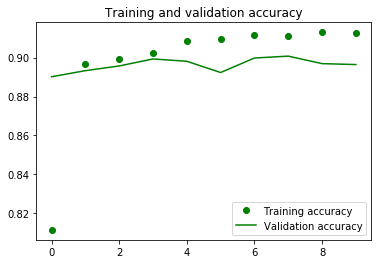

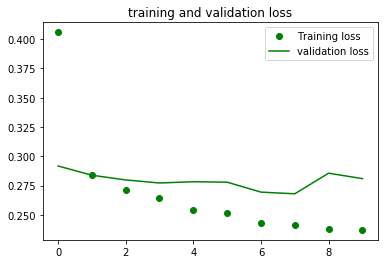

In [277]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

### Predicting with Test Data

In [282]:
predict = model.predict_classes(xvalid)
predict

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [283]:
#confusion matrix
confusion_matrix(yvalid, predict)

array([[1876,  256],
       [ 175, 1853]])

In [285]:
#accuracy of the model
accuracy_score(yvalid,predict)

0.8963942307692307

### Reading Test Data

In [288]:
test_data = pd.read_csv('/home/hasan/DATA SET/Fake News/processed test data.csv')

In [291]:
#predicting with test data
predict = model.predict_classes(test_data)

In [292]:
predict

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

Note: Need more hyperparameter tuning. Because from the train and validation graph
    we are seeing curve is not smooth.